# Clasificación de imágenes con modelos de *ensemble*
Este notebook muestra el proceso de análisis, preprocesamiento y entrenamiento de modelos para predecir la clase de imágenes de distintos escenarios.

## 1. Setup

Librerías importadas en el proyecto.

In [ ]:
import numpy as np
import pandas as pd

import os
import warnings
import gc

from IPython.display import IFrame

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from skimage.exposure import rescale_intensity
from skimage.transform import resize

from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

Variables globales declaradas en el proyecto.

In [ ]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

DATASETS = ["train", "test"]
CATEGORIES = ["edificios", "glaciares", "montanas", "mares", "bosques", "calles"]
IMG_SHAPE = (150, 150, 3)

DATA_PATH = os.path.join(os.pardir, "data")  # Path to csv data
INFO_PATH = os.path.join(os.pardir, "info")  # Path to problem info
RESULTS_PATH = os.path.join(os.pardir, "results")  # Path to results files

Enunciado del problema.

In [ ]:
IFrame(os.path.join(INFO_PATH, "lab2.pdf"), width=1080, height=920)

## 2. Análisis exploratorio de los datos

En primer lugar, vamos a cargar los datos en memoria.

In [ ]:
dataframes = {}

for dataset in DATASETS:
    dataset_path = os.path.join(DATA_PATH, dataset)
    data = []
    for category in os.listdir(dataset_path):
        print(f"Reading category {category} from {dataset} set...")
        category_path = os.path.join(dataset_path, category)
        for file in filter(lambda x: x.endswith(".jpg"), os.listdir(category_path)):
            data.append({
                "img": plt.imread(os.path.join(category_path, file)),
                "label": category
            })
    dataframes[dataset] = pd.DataFrame(data)
    del data

Con todo cargado en memoria, vamos a hacer una primera visualización de los datos que tenemos. Cogeremos una muestra aleatoria para echar un vistazo a las imágenes.

In [ ]:
np.random.seed(RANDOM_SEED)
for category in CATEGORIES:
    print(category)
    category_df = dataframes["train"][dataframes["train"]["label"] == category]
    fig, ax = plt.subplots(1, 5, figsize=(20, 8))
    for i, index in enumerate(np.random.randint(0, len(category_df), size=(5,))):
        ax[i].imshow(category_df["img"].iloc[index])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

Lo primero que podemos detectar es que hay una imagen con un tamaño distinto al resto en la categoría de `glaciares`. Es algo que tendremos que tratar más adelante. Podemos ver otras cosas, como que el color va a ser un elemento muy relevante a la hora de decidir si la imagen pertenece a `bosques` o a `glaciares`. También vemos que va a ser difícil distinguir entre `montanas` y `glaciares`, y entre `calles` y `edificios`.

### 2.1 Proporción de clases en los datos

Un aspecto importante del que nos tenemos que preocupar es que las clases estén equilibradas en el conjunto de entrenamiento. Una clase demasiado predominante nos puede dar problemas sesgando a los modelos, así que vamos a elaborar gráficos para comprobar si es el caso.

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i, dataset in enumerate(DATASETS):
    counts = dataframes[dataset]["label"].value_counts()
    counts = {key: val for key, val in sorted(counts.items(), key=lambda x: x[0])}
    ax[i].pie(x=list(counts.values()), autopct="%.1f%%", explode=[0.01]*len(counts), labels=[l.title() for l in counts.keys()], pctdistance=0.5)
    ax[i].set_title(f"Distribution of categories in {dataset} set", fontdict={"size": 14, "font": "Consolas"})

La distribución de las etiquetas es casi uniforme. Esto va a ser muy beneficioso para el entrenamiento.

### 2.2 Tamaños inconsistentes en las imágenes

En el enunciado del problema nos dicen que todas las imágenes tienen un tamaño de 150x150 píxeles. Sin embargo, en una muestra aleatoria que hemos escogido hemos visto una imagen que claramente tiene otro tamaño. Vamos a ver si se da en otros ejemplos.

In [ ]:
for dataset in DATASETS:
    print(f"****{dataset.upper()}****")
    for category in CATEGORIES:
        print(f"----{category}----")
        category_df = dataframes["train"][dataframes["train"]["label"] == category]
        for shape in filter(lambda x: x != (150, 150, 3), [x.shape for x in category_df["img"]]):
            print(shape)

En todos estos casos nos faltan filas completas de píxeles: el número de columnas siempre es 150 (el esperado) y el número de filas es siempre inferior a 150. Podríamos plantearnos hacer un *padding* y completar estas filas con ceros, pero ya que nos faltan relativamente pocas filas (excepto en unas pocas instancias) podremos simplemente hacer un *resize* al tamaño adecuado.

### 2.3 Análisis de exposición

Vamos a mirar si nos puede interesar regular la exposición de las imágenes.

En un plot, vamos a mostrar las imágenes antes y después de corregir su exposición, para ver si hacerlo puede ayudar al entrenamiento.

In [ ]:
for category, index in zip(CATEGORIES, np.random.randint(0, len(category_df), size=len(CATEGORIES))):
    print(category)
    category_df = dataframes["train"][dataframes["train"]["label"] == category]
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    image = category_df["img"].iloc[index]    
    ax[0].imshow(image)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Before rescaling intensity")
    ax[0].grid()
    rgb = [image[:, :, color] for color in [0, 1, 2]]
    img_corrected = np.zeros_like(image)
    for color, color_index in zip(["r", "g", "b"], [0, 1, 2]):
        single_color_image = image[:, :, color_index]
        ax[1].hist(single_color_image.ravel(), bins=255, color=color, label=color, alpha=0.8)
        p_min, p_max = np.percentile(single_color_image, (5, 95))
        img_corrected[:, :, color_index] = rescale_intensity(single_color_image, in_range=(p_min, p_max))
    ax[1].legend()
    ax[1].set_title("Intensity histogram")
    ax[2].imshow(img_corrected)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title("After rescaling intensity")
    plt.show()

Parece que este paso consigue que la calidad de la imagen en general mejore ligeramente. Por tanto, será un paso del preprocesamiento.

### 2.4 Imágenes en blanco y negro

Como hemos visto, el color va a jugar un papel fundamental para distinguir algunas clases (como la diferencia entre montañas y glaciares). Por eso, las imágenes en blanco y negro podrían añadir ruido al modelo. Vamos a ver si hay muchas de esas.

1 grayscale images in train set


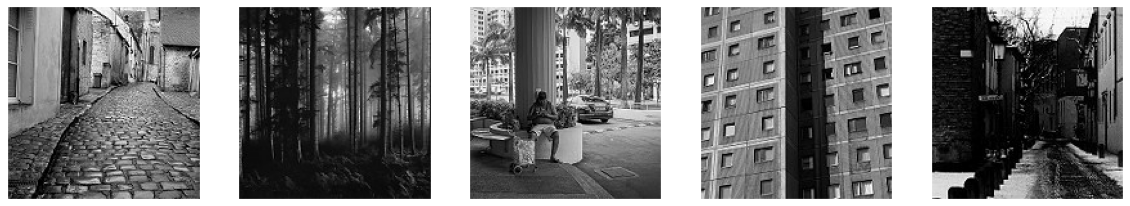

2 grayscale images in test set


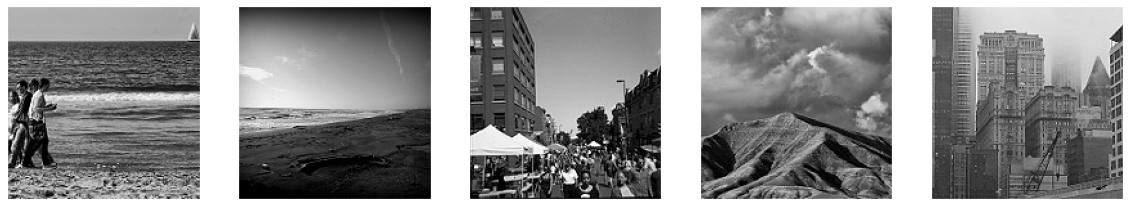

In [19]:
def is_black_white(image):
    if len(image.shape) == 2:
        return True
    else:
        assert image.shape[-1] == 3
        channels = [image[:, :, i] for i in range(3)]
        eq1 = np.array_equal(channels[0], channels[1])
        eq2 = np.array_equal(channels[1], channels[2])
        return eq1 and eq2

bw = {}
for dataset in DATASETS:
    isbw = dataframes[dataset]["img"].apply(is_black_white)
    bw[dataset] = isbw[isbw]
    print(f"{len(bw)} grayscale images in {dataset} set")

    fig, ax = plt.subplots(1, 5, figsize=(20, 8))
    for i, index in enumerate(bw[dataset].sample(n=5, random_state=RANDOM_SEED).index):
        ax[i].imshow(dataframes[dataset]["img"].iloc[index])
        ax[i].grid()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

Ahora vamos a eliminar las imágenes correspondientes.

In [20]:
for dataset in DATASETS:
    dataframes[dataset].drop(bw[dataset].index, inplace=True)

## 3. Preprocesamiento

Vamos a empezar a montar el pipeline de preprocesamiento para las imágenes. Lo primero que vamos a hacer es convertir los DataFrames en arrays de NumPy.

In [ ]:
X_train, y_train = dataframes["train"]["img"].to_numpy(), dataframes["train"]["label"].to_numpy()
X_test, y_test = dataframes["test"]["img"].to_numpy(), dataframes["test"]["label"].to_numpy()
del dataframes
X_train.shape, y_train.shape, X_test.shape, y_test.shape
X_train

### 3.1 *Resize*

Vamos a añadir un componente `resize_image` para que todas las imágenes tengan el tamaño deseado. Utilizamos [resize](https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=resize#skimage.transform.resize) del paquete `skimage.transform`, que no modifica la imagen si ya tiene las dimensiones especificadas.

In [ ]:
def resize_funct(X, output_shape=IMG_SHAPE):
    ret = np.zeros_like(X)
    for index, image in enumerate(X):
        ret[index] = resize(image, output_shape=output_shape)
    return ret

resize_image = FunctionTransformer(resize_funct)

### 3.2 Ajuste de la exposición

Podemos hacer el ajuste de la intensidad de los píxeles, como hemos visto anteriormente, para mejorar ligeramente la calidad de la imagen.

In [ ]:
def adjust_exposure_funct(X):
    ret = np.zeros((len(X), *IMG_SHAPE), dtype=np.int)
    for index, image in enumerate(X):
        for channel in [0, 1, 2]:
            channel_image = image[:, :, channel]
            pmin, pmax = np.percentile(channel_image, (5, 95))
            ret[index, :, :, channel] = rescale_intensity(channel_image, in_range=(pmin, pmax))
    return ret

adjust_exposure = FunctionTransformer(adjust_exposure_funct)

### 3.2 *Flatten*

Lo siguiente va a ser convertir las imágenes en una fila de una sola dimensión. Para ello vamos a usar el método `flatten` de NumPy.

In [ ]:
flatten = FunctionTransformer(lambda X: np.array([x.flatten() for x in X]))

### 3.3 *Scale*

Por último, vamos a escalar cada uno de los píxeles (dividido por canal) restando la media y dividiendo por la desviación típica del píxel.

In [ ]:
def center(X):
    return X - X.mean()

def scale(X):
    return X / X.std()

scaling = StandardScaler()#Pipeline([
    #("center", FunctionTransformer(center)),
    #("scale", FunctionTransformer(scale))
#])

### 3.4 Pipeline completo y preprocesamiento de los datos

Además de montar el pipeline completo para las imágenes, vamos a codificar las etiquetas en arrays numéricos.

In [ ]:
full_pipeline = Pipeline([
    ("resize", resize_image),
    ("adjust_exposure", adjust_exposure),
    ("flatten", flatten),
    ("scaling", scaling)
], verbose=True)

label_encoder = LabelEncoder()

In [ ]:
print("Processing fit_transform on train...")
X_train_preprocessed = full_pipeline.fit_transform(X_train)
y_train_preprocessed = label_encoder.fit_transform(y_train)
del X_train, y_train
gc.collect()
print("\nProcessing transform on test...")
X_test_preprocessed = full_pipeline.transform(X_test)
y_test_preprocessed = label_encoder.transform(y_test)
del X_test, y_test
gc.collect()
print("Done.")

---
Creado por **Diego Trujillo** (diego.trujillo.jimenez@alumnos.upm.es) y **Ángel Acevedo** (angel.acevedo.sanchez@alumnos.upm.es) 

<br></br>
[![License: GPL v2](https://img.shields.io/badge/License-GPL%20v2-blue.svg)](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html)